In [35]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import argrelextrema
from numba import njit
plt.rcParams["animation.html"] = "jshtml"

In [74]:
# Constantes
mu = 39.4234021  #Parámetro gravitacional en AU^3/Year^2

# Parámetros orbitales de Mercurio
a = 0.38709893  # Semieje mayor en UA
e = 0.20563069  # Excentricidad

# Condiciones inicial
x0 = a * (1 + e)  # x(t=0)
y0 = 0.0         # y(t=0)

# Velocidad inicial
v_y0 = np.sqrt(mu / a) * np.sqrt((1 - e) / (1 + e))
v_x0 = 0.0

# Parámetro relativista α
alpha = 1.09778201e-8  # Valor real en AU^2

# Tiempo de simulación
t_span = (0, 10)  # Simulación durante 10 años
t_paso = np.linspace(t_span[0], t_span[1], int(2e4))  # Resolución temporal

In [75]:

def EDO(t, state):
    """
    Define las ecuaciones diferenciales del sistema.
    state = [x, y, vx, vy]
    """
    x, y, vx, vy = state
    r = np.sqrt(x**2 + y**2)  # Distancia al Sol
    r_dir = np.array([x, y]) / r  # Vector unitario radial

    # Fuerza gravitacional con corrección relativista
    a = -(mu / r**2) * (1 + alpha / r**2)

    # Aceleración
    ax = a * r_dir[0]
    ay = a * r_dir[1]

    return [vx, vy, ax, ay]

In [76]:
# Condiciones iniciales
c_iniciales = [x0, y0, v_x0, v_y0]

# Resolver las ecuaciones diferenciales

solucion = solve_ivp(
    EDO,
    t_span=t_span,
    y0=c_iniciales,
    t_eval=t_paso,
    method="RK45",
    rtol=1e-8,
    atol=1e-8
)

# Extraer resultados
x = solucion.y[0]
y = solucion.y[1]
vx = solucion.y[2]
vy = solucion.y[3]
t = solucion.t


In [55]:
%%capture
# Crear la figura y los ejes
fig, ax = plt.subplots()
plt.title("Precesión de Mercurio")
plt.scatter([0], [0], color='yellow', label="Sol")  # Marcar el Sol
ax.set_xlim(-0.5, 0.5)  # Límites del eje x
ax.set_ylim(-0.5, 0.5)  # Límites del eje y
ax.set_aspect('equal')  # Aspecto igual para x e y

# Crear la línea para la trayectoria
line, = ax.plot([], [], lw=2, label="Órbita de Mercurio")

# Crear el punto para la posición actual
point, = ax.plot([], [], 'ro', label="Mercurio")

# Añadir leyenda
plt.legend(loc="upper left")

In [56]:
# Función de inicialización
def init():
    line.set_data([], [])  # Línea vacía
    point.set_data([], [])  # Punto vacío
    return line, point

step = 100000  # Muestra 1 de cada 10 puntos
t_anim = t[::step]
x_anim = x[::step]
y_anim = y[::step]
# Función de actualización
def animate(i):
    # Actualizar la línea con los datos hasta el cuadro i
    line.set_data(x_anim[:i], y_anim[:i])

    # Actualizar el punto con la posición actual
    point.set_data([x_anim[i-1]], [y_anim[i-1]])

    return line, point

# Crear la animación
ani = FuncAnimation(
    fig,                # Figura
    animate,            # Función de actualización
    frames=len(t_anim),      # Número de cuadros
    init_func=init,     # Función de inicialización
    blit=True,           # Optimización
)

# Guardar la animación como un archivo mp4
ani.save("3.a.mp4")

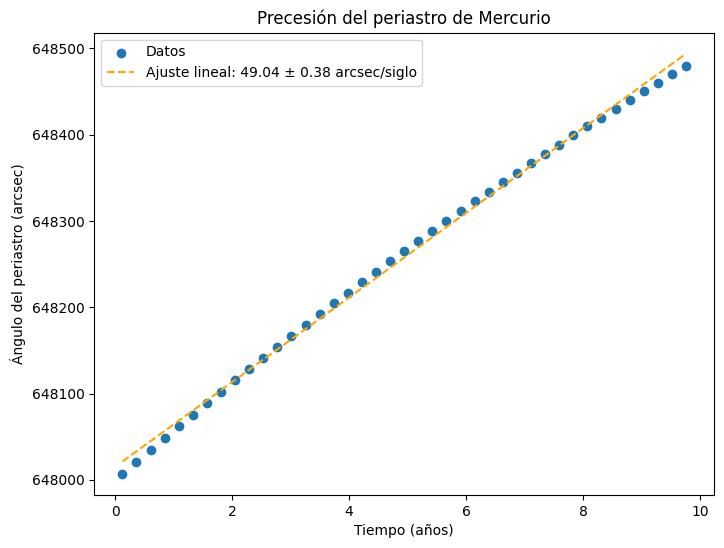

 Se calculó una precesión para el periastro de 49.04 ± 0.38 arcsec/siglo. Así, basado en la literatura de una precesión de 42.9799 arc/siglo, se puede ver que hay un error porcentual de al menos 13,2%


In [80]:
# Calcular ángulo theta en radianes
theta = np.arctan2(y, x)

# Identificar periastros (mínimos en r)
r = np.sqrt(x**2 + y**2)
peri_idx = argrelextrema(r, np.less)[0]
theta_peri = theta[peri_idx]
t_peri = t[peri_idx]

# Convertir ángulos a arcosegundos
theta_peri_arcsec = np.mod(np.unwrap(theta_peri) * (3600 * 180 / np.pi),3600*360)

# Ajuste lineal
(m, b), cov = np.polyfit(t_peri, theta_peri_arcsec, 1, cov=True)

# Extraer incertidumbre (desviación estándar) de la pendiente y la intersección
m_err = np.sqrt(cov[0, 0])  # Incertidumbre en la pendiente
b_err = np.sqrt(cov[1, 1])  # Incertidumbre en la intersección

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(t_peri, theta_peri_arcsec, label="Datos", color="C0")
plt.plot(t_peri, m * t_peri + b, "--", label=f"Ajuste lineal: {m:.2f} ± {m_err:.2f} arcsec/siglo", color="orange")
plt.xlabel("Tiempo (años)")
plt.ylabel("Ángulo del periastro (arcsec)")
plt.title("Precesión del periastro de Mercurio")
plt.legend()
plt.savefig("3.b.pdf")
plt.show()

# Mostrar la pendiente calculada
print(f" Se calculó una precesión para el periastro de {m:.2f} ± {m_err:.2f} arcsec/siglo. Así, basado en la literatura de una precesión de 42.9799 arc/siglo, se puede ver que hay un error porcentual de al menos 13,2%")